In [187]:
from datacube import *
import masks as mask
import extras as ex
import flow_fields as ff
import director_field as director

## troubleshooting
from skimage import exposure

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [188]:
# Pytorch setup 
cuda = torch.device('cuda')
torch.cuda.get_device_name(cuda)

'TITAN V'

## Parameters

In [189]:
# Microscope parameters
dx = 1.924   # Pixel resolution (angstrom /pixel) - UPDATED from 1.94873

# Image processing parameters
N = 32   # Size of nano-image in pixels
NN = 128   # size of FFT
step_size = 8

# Material system parameters
q = 0.28
d = (2 * math.pi)/q

sigma_q = 0.02# desired q bandwidth
sigma_th = 0.05 # desired theta bandwidth
q = 2 * math.pi / d

#Angles
angles = np.linspace(-80, 90, 18)
# angles = np.linspace(-89, 90, 180)
print('angles: ' + str(angles))

angles: [-80. -70. -60. -50. -40. -30. -20. -10.   0.  10.  20.  30.  40.  50.
  60.  70.  80.  90.]


## Plot HRTEM

In [190]:
pwd = '/home/camila/hrtem_rawData/20190714_Bao_A01_NN/'
fn = 'A01_NN_mosaic4_00015.mrc'

data = read_mrc(pwd + fn)
print(data.shape)

(24, 3838, 3710)


hrtem_tensor is tensor?: True
sending tensor to GPU


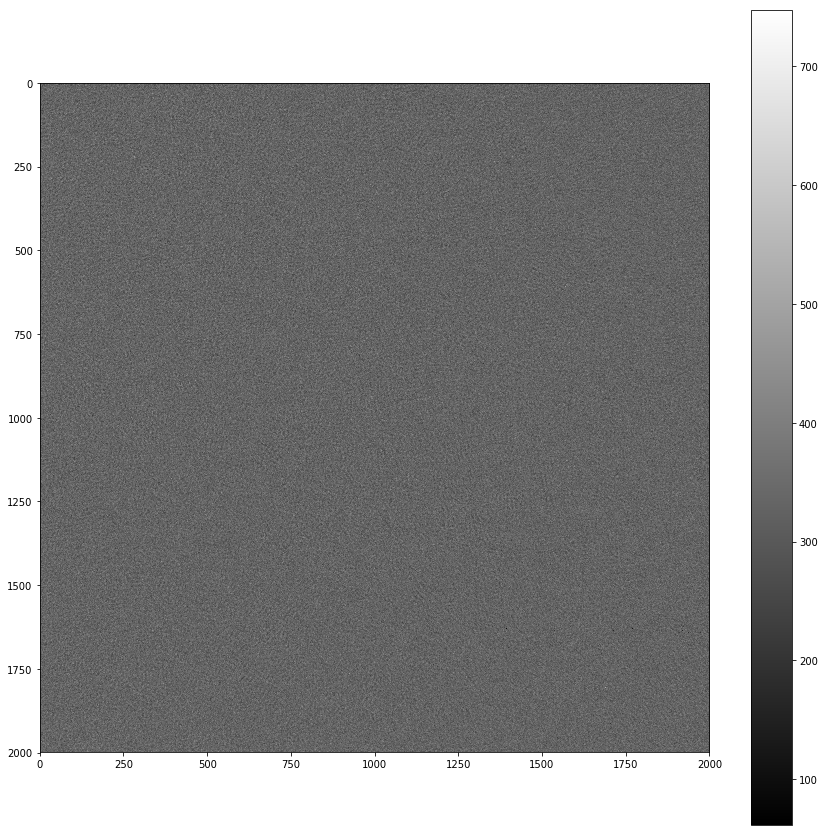

In [191]:
stack_range = 24
stack_data = stack_image(data[:stack_range, :, :])

img_size = 2000

img_np = stack_image(data[:stack_range, :, :])[-img_size:, -img_size:]
# img_np = stack_image(data[:stack_range, :, :])

# get hrtem image tensor. 
# NOTE: tensor and numpy share the same memory in CPU!
img_tensor = torch.from_numpy(img_np)
print('hrtem_tensor is tensor?: ' + str(torch.is_tensor(img_tensor)))

print('sending tensor to GPU')
img_tensor_gpu = img_tensor.to(cuda)   # tensor send to gpu not related in memory to numpy

gamma_corrected = exposure.adjust_gamma(img_np, 0.75)

plt.figure(figsize=(15, 15))
# plt.imshow(img_np, cmap='gray')
plt.imshow(gamma_corrected, cmap='gray')
plt.colorbar()
plt.show()

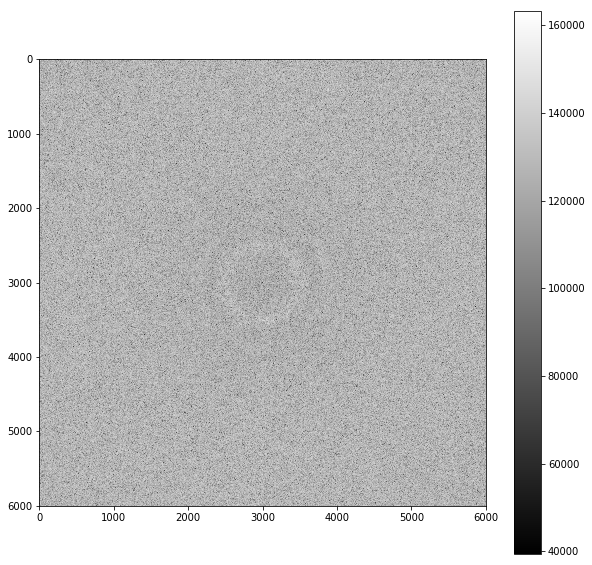

In [177]:
img_fft_gpu = tensor_fft(normalize_tensor(img_tensor_gpu), s=6000)

plt.figure(figsize=(10, 10))
plt.imshow(100* np.log(img_fft_gpu.cpu())**2, cmap='gray')
plt.colorbar()
plt.show()

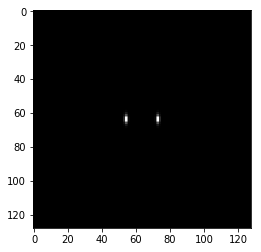

In [178]:
# Gaussian q filter (no rotation):
gaussian_q_filter = mask.gaussian_q_filter(q, sigma_q, sigma_th, N, NN, dx)

# plt.imshow(gaussian_q_filter, cmap='gray')
# plt.show()

In [179]:
# Time estimation --> 55x speed increase when using PyTorch
operations = ((img_tensor_gpu.shape[0] - N)/step_size + 1)**2
print("expected number of operations (n^2): " + str(operations))
operation_rate = 111/212291

print('expected operation time (seconds): ' + str(operations*operation_rate))

expected number of operations (n^2): 61009.0
expected operation time (seconds): 31.899604787767736


In [180]:
# 1) Get datacube

output_fn = 'blah.npy'

img_datacube = get_datacube(img_tensor_gpu, angles, step_size, q, output_fn, sigma_q, sigma_th, N, NN, device='cuda', dx=dx, plot=False)
# img_datacube_median = f.median_filter(img_datacube_median, device=cuda, size=1)
# output = np.load('blah.npy')

row:  0
row:  50
row:  100
row:  150
row:  200
Processing time to get 4D datacube [seconds]: 30.812018632888794


In [181]:
print('image datacube shape: ' + str(img_datacube.shape))
m, n, k = img_datacube.shape

pwd = '/home/camila/PycharmProjects/2019_may/dark_references/'
df_mean = torch.from_numpy(np.load(pwd + 'df_angular_mean.npy')).to(cuda)[:m, :n, :]
df_std = torch.from_numpy(np.load(pwd + 'df_angular_std.npy')).to(cuda)[:m, :n, :]

factor = 7
print('dark reference mean shape: ' + str(df_mean.shape))

image datacube shape: torch.Size([247, 247, 18])
dark reference mean shape: torch.Size([247, 247, 18])


/home/camila/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


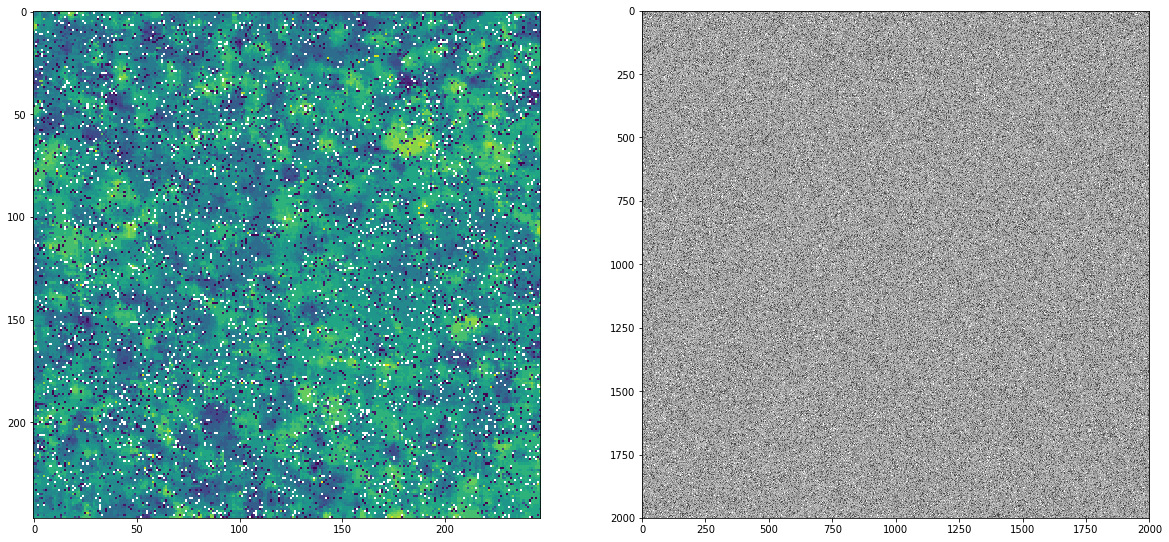

In [182]:
# 3) Get tensor with max intensity of peaks a
peak_tensor, orientation_df, peak_intensity_tensor = director.search_peaks(img_datacube, df_mean, df_std, factor, angles)
img_filtered = median_filter(img_tensor_gpu, device=cuda)
orientation_filtered = ndimage.median_filter(orientation_df, size=8)

peak_intensity_tensor = median_filter(peak_intensity_tensor, device=cuda, size=8)

plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(orientation_filtered)
plt.subplot(1,2,2)
plt.imshow(np.log(img_filtered.cpu().numpy()), cmap='gray')
plt.show()

Seeding Flow Lines...


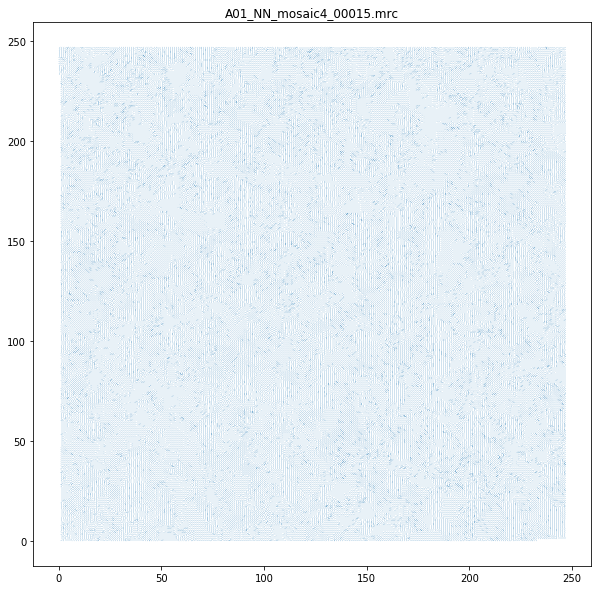

/home/camila/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


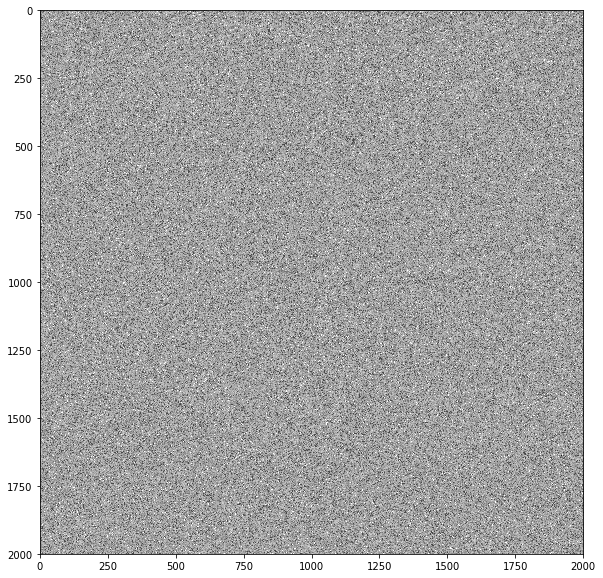

In [183]:
matrix = ndimage.rotate(peak_intensity_tensor.cpu().numpy(), -90)
threshold_datacube = df_mean + factor * df_std

print('Seeding Flow Lines...')
# line_seeds, peak_matrix = ff.seed_lines(matrix, threshold_datacube.cpu().numpy(), maxes_only=True, min_spacing=10)
line_seeds, peak_matrix = ff.seed_lines(matrix, maxes_only=True, min_spacing=10)
ff.preview_line_plot(line_seeds, (10, 10))
directors = plt.gcf()
plt.title(fn)
# plt.savefig(pwd + 'seed_lines_' + fn[:-4] + '.tif')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(np.log(img_tensor_gpu.cpu().numpy()), cmap='gray')
# plt.colorbar()
plt.show()

Propagating Flow Lines...
0%
5 %            0:20  remaining
10 %            0:19  remaining
15 %            0:17  remaining
20 %            0:17  remaining
25 %            0:15  remaining
30 %            0:14  remaining
35 %            0:13  remaining
40 %            0:12  remaining
45 %            0:11  remaining
50 %            0:10  remaining
55 %            0:09  remaining
60 %            0:08  remaining
65 %            0:07  remaining
70 %            0:06  remaining
75 %            0:05  remaining
80 %            0:04  remaining
85 %            0:03  remaining
90 %            0:02  remaining
95 %            0:01  remaining
Finished in  0:21
100 %            0:00  remaining
Total Time  0:22


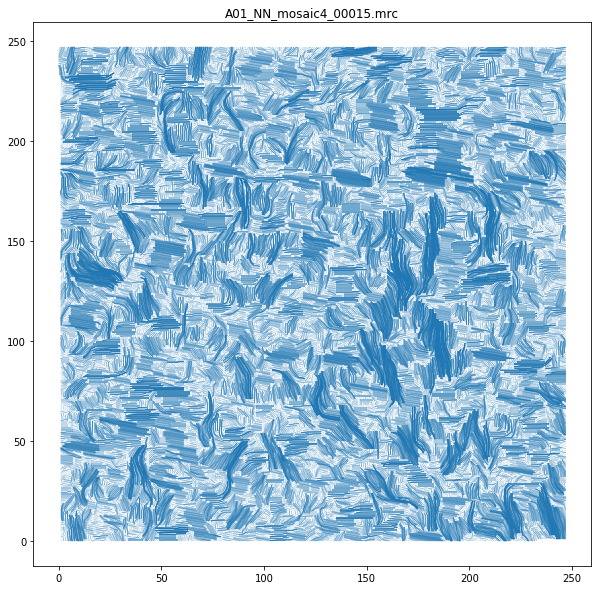

/home/camila/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


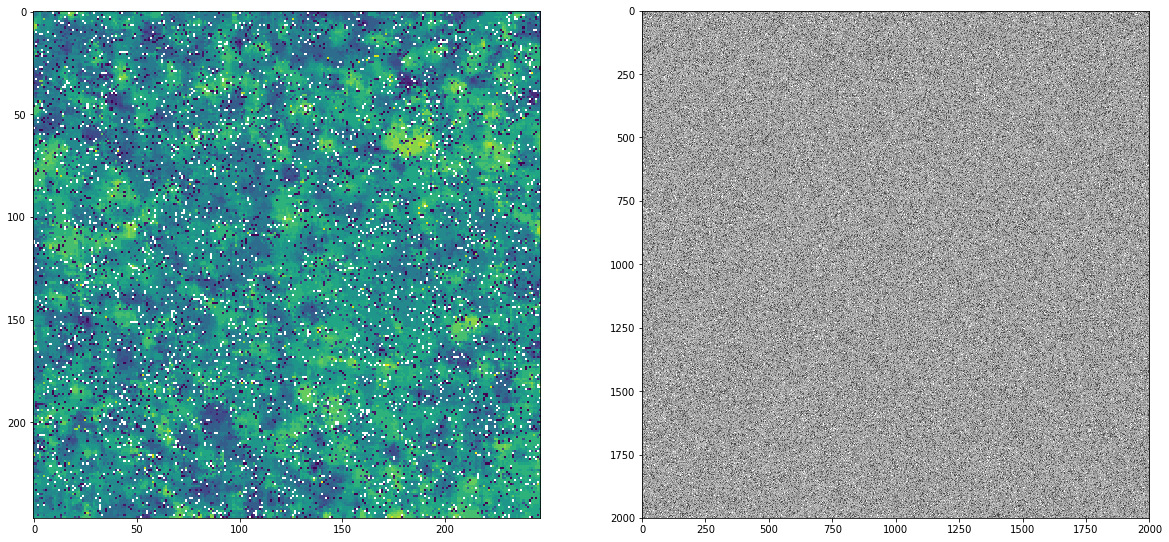

In [184]:
print('Propagating Flow Lines...')
progress_bar = ex.ProgressBar(len(line_seeds))
for line in line_seeds:
    line.propagate_2(peak_matrix, bend_tolerance=20)
    progress_bar.update('+1')

ff.preview_line_plot(line_seeds, (10,10))
propagated = plt.gcf()
plt.title(fn)
# plt.savefig(pwd + 'flow_lines_' + fn[:-4] + '.tif')
plt.show()

plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(orientation_filtered)
plt.subplot(1,2,2)
plt.imshow(np.log(img_filtered.cpu().numpy()), cmap='gray')
plt.show()

Trimming Lines...


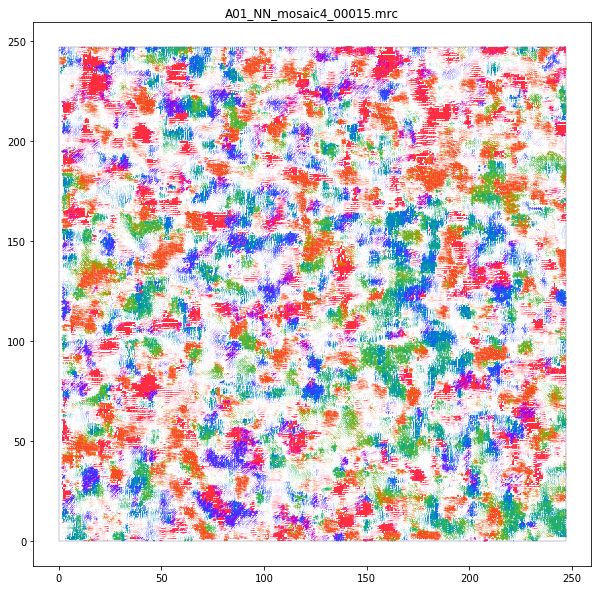

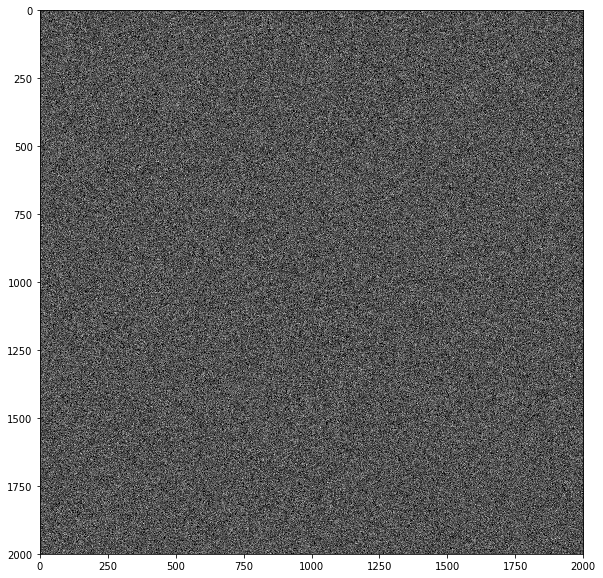

In [185]:
min_length = 2  # Must pass outside origninal box to be drawn
window_shape = (20, 60, 20, 60)
window = False

ff.trim_and_color(line_seeds, matrix, min_length, (10, 10), window=window, window_shape=window_shape)
flow_field = plt.gcf()
plt.title(fn)
plt.savefig('test.tif')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(gamma_corrected, cmap='gray')
# plt.colorbar()
plt.show()

Trimming Lines...


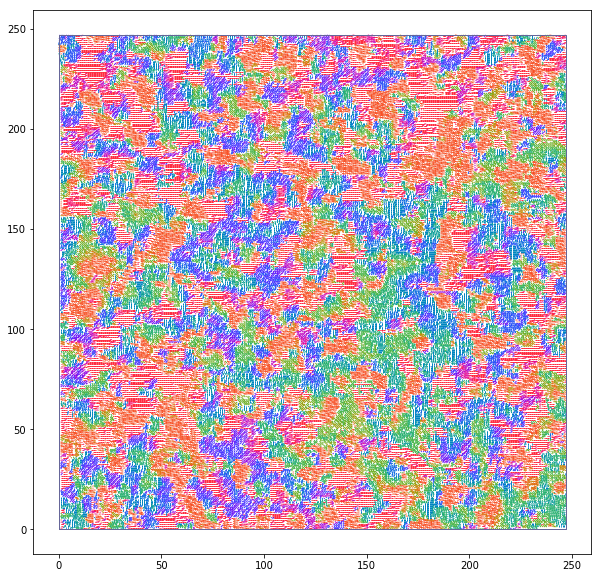

In [186]:
ff.trim_and_color(line_seeds, matrix, min_length, (10, 10), window=window, window_shape=window_shape, intensities=False)
unweighted_flow_field = plt.gcf()
# plt.savefig(pwd + 'unweighted_flow_field_' + fn[:-4] + '.tif')
plt.show()